# Classification, Probabilities, and the Confusion Matrix

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn.apionly as sns

C:\Users\user\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
C:\Users\user\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\user\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
C:\Users\user\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
C:\Users\user\Anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.level rcparam was deprecated in 

We are going to encapsulate some code into handy-dandy functions that we can use for easier model training using cross-validation

In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val,mode="mask", reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    """
    Classification made simple (or is it more complex?)
    THIS WORKS FOR 2 Class Classification problems only
    parameters: parameter grid in the sklearn style
    indf: dataframe you feed in
    featurenames: list of columnames corresponding to features you want in your model
    targetname: the column you want to use as target
    target1val: the value of the "targetname" column
    mode: mask or split. mask a boolean mask to choose train/test or
        split a dictionary with keys Xtrain/Xtest/ytrain/ytest and values existing
        training and test sets in the canonical form
    reuse_split: the actual mask above or the actuall ditionary, depending upon which
        modu you chose
    score_func: this is from GridSearchCV
    n_folds: cross val folds
    n_jobs: mumber of processes to use in cross-validation
    
    We return classifier, and the train and test sets. We print accuracies
    and the confusion matrix
    """
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mode=="mask":
        print("using mask")
        Xtrain,Xtest,ytrain,ytest= X[mask],X[~mask],y[mask],y[~mask]
        mask=reuse_split
    else:
        print("using reuse split")
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']#doubt
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("############# based on standard predict ################")
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data:     %0.2f" % (test_accuracy))
    print(confusion_matrix(ytest, clf.predict(Xtest)))
    print("########################################################")
    return clf, Xtrain, ytrain, Xtest, ytest

In [5]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14)
    return ax 

## Setting up the data

(I encountered this dataset in Conway, Drew, and John White. Machine learning for hackers. " O'Reilly Media, Inc.", 2012.)

In [56]:
dfhw=pd.read_csv("data/01_heights_weights_genders.csv")
dfhw.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [57]:
dfhw.shape

(10000, 3)

We sample 500 points from 10,000, since we actually want to see trends clearly on the plots

In [80]:
df=dfhw.sample(500, replace=False)
np.sum(df.Gender=="Male")

259

We split the data into training and test sets...and setup a mask so we can reuse these splits later

In [81]:
itrain, itest = train_test_split(range(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]

array([False, False,  True,  True, False,  True, False, False,  True,
        True])

## Logistic regression


$$
\renewcommand{\like}{{\cal L}}
\renewcommand{\loglike}{{\ell}}
\renewcommand{\err}{{\cal E}}
\renewcommand{\dat}{{\cal D}}
\renewcommand{\hyp}{{\cal H}}
\renewcommand{\Ex}[2]{E_{#1}[#2]}
\renewcommand{\x}{{\mathbf x}}
\renewcommand{\v}[1]{{\mathbf #1}}
$$


Previously, we saw the loss for Logistic regression and noted that it is a loss for probability estimation...and not a loss for making decisions. We'll go into these dual losses soon..

$$R_{\cal{D}}(h(x)) = -\loglike = -log \like = - log(P(y|\v{x},\v{w})).$$


Thus

\begin{eqnarray*}
R_{\cal{D}}(h(x)) &=& -log\left(\prod_{y_i \in \cal{D}} h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\
                  &=& -\sum_{y_i \in \cal{D}} log\left(h(\v{w}\cdot\v{x_i})^{y_i} \left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\right)\\                  
                  &=& -\sum_{y_i \in \cal{D}} log\,h(\v{w}\cdot\v{x_i})^{y_i} + log\,\left(1 - h(\v{w}\cdot\v{x_i}) \right)^{(1-y_i)}\\
                  &=& - \sum_{y_i \in \cal{D}} \left ( y_i log(h(\v{w}\cdot\v{x})) + ( 1 - y_i) log(1 - h(\v{w}\cdot\v{x})) \right )
\end{eqnarray*}

where

$$h(z) = \frac{1}{1 + e^{-z}}.$$



Notice that its L2 regularized.... by default

In [1]:
from sklearn.linear_model import LogisticRegression
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog = LogisticRegression(solver='lbfgs')
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Height','Weight'],'Gender', "Male", mode="mask", reuse_split=mask)

NameError: name 'do_classify' is not defined

In `sklearn`, `clf.predict(test_data)` makes predictions on the assumption that a 0.5 probability threshold is the appropriate thing to do. Make predictions on the test set

In [83]:
# your code here
clflog.fit(Xtrain,ytrain)
clflog.predict(Xtest)


array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1])

In `sklearn`, `predict_proba` gives us the probabilities. Find the probabilities on the test set.

In [108]:
clflog.predict_proba(Xtest)

array([0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1])

What do these probabilities correspond to? The second column (`[:,1]` in numpy parlance, google numpy indexing to understand the syntax) gives the probability that the sample is a 1 (or +ive), here Male.

Make a histogram of these probabilities. Interpret them.

(array([69., 15.,  9.,  6.,  2.,  4.,  4.,  9., 11., 71.]),
 array([8.66274043e-04, 1.00756658e-01, 2.00647042e-01, 3.00537427e-01,
        4.00427811e-01, 5.00318195e-01, 6.00208579e-01, 7.00098964e-01,
        7.99989348e-01, 8.99879732e-01, 9.99770116e-01]),
 <a list of 10 Patch objects>)

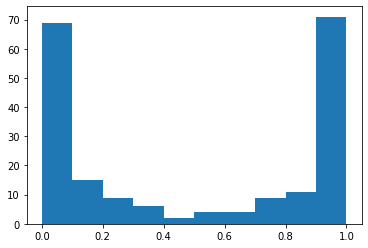

In [85]:
# your code here
plt.hist(clflog.predict_proba(Xtest)[:,1])

Lots of sure females and sure males when you plot the probability of being a male. 

At this point you might want to see how this histogram looks in the 2 dimensional space of our predictors.

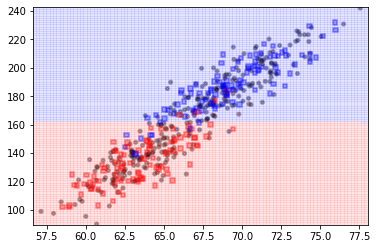

In [87]:
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()

with sns.plotting_context('poster'):
    points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

We can plot the probability contours: these are rather tight!

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'axes'
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The following kwargs were not used by contour: 'axes'
  if __name__ == '__main__':


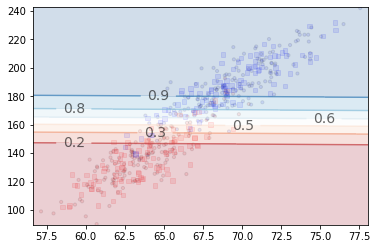

In [90]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);


The score function of the estimator is used to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression. For some applications, other scoring functions are better suited (for example in unbalanced classification, the accuracy score is often uninformative). We can pass other scorers to `GridSearchCV`.

In [92]:
clflog.score(Xtest, ytest)
#clflog.score(Xtrain,ytrain)

0.935

## The confusion Matrix

 A classifier will get some samples right, and some wrong. Generally we see which ones it gets right and which ones it gets wrong on the test set. There,

- the samples that are +ive and the classifier predicts as +ive are called True Positives (TP)
- the samples that are -ive and the classifier predicts (wrongly) as +ive are called False Positives (FP)
- the samples that are -ive and the classifier predicts as -ive are called True Negatives (TN)
- the samples that are +ive and the classifier predicts as -ive are called False Negatives (FN)

A classifier produces a confusion matrix from these which lookslike this:

![hwimages](./images/confusionmatrix.png)


IMPORTANT NOTE: In sklearn, to obtain the confusion matrix in the form above, always have the observed `y` first, i.e.: use as `confusion_matrix(y_true, y_pred)`

In [93]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[93,  5],
       [ 8, 94]], dtype=int64)

Given these definitions, we typically calculate a few metrics for our classifier. First, the **True Positive Rate**:

$$TPR = Recall = \frac{TP}{OP} = \frac{TP}{TP+FN},$$

also called the Hit Rate: the fraction of observed positives (1s) the classifier gets right, or how many true positives were recalled. Maximizing the recall towards 1 means keeping down the false negative rate. In a classifier try to find cancer patients, this is the number we want to maximize.

The **False Positive Rate** is defined as

$$FPR = \frac{FP}{ON} = \frac{FP}{FP+TN},$$

also called the False Alarm Rate, the fraction of observed negatives (0s) the classifier gets wrong. In general, you want this number to be low. Instead, you might want to maximize the
**Precision**,which tells you how many of the predicted positive(1) hits were truly positive

$$Precision = \frac{TP}{PP} = \frac{TP}{TP+FP}.$$

Finally the **F1** score gives us the Harmonic Score of Precision and Recall. Many analysts will try and find a classifier that maximizes this score, since it tries to minimize both false positives and false negatives simultaneously, and is thus a bit more precise in what it is trying to do than the accuracy.

$$F1 =  \frac{2*Recall*Precision}{Recall + Precision}$$

However, in a case like that of a cancer classifier, we will wish to minimize false nagatives at the expense of false positives: it is ok to send perfectly healthy patients for cancer folloup if that is the price we must pay for not missing any sick ones.

`scikit-learn` helpfully gives us a classification report with all these numbers

In [94]:
from sklearn.metrics import classification_report
print(classification_report(ytest, clflog.predict(Xtest)))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        98
           1       0.95      0.92      0.94       102

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.93       200
weighted avg       0.94      0.94      0.94       200



#### The cancer doctor

Do you really want to be setting a threshold of 0.5 probability to predict if a patient has cancer or not? The false negative problem: ie the chance you predict someone dosent have cancer who has cancer is much higher for such a threshold. You could kill someone by telling them not to get a biopsy. Why not play it safe and assume a much lower threshold: for eg, if the probability of 1(cancer) is greater than 0.05, we'll call it a 1.

Write a function `t_repredict(est,t, Xtest)` which takes your classifier, a probability threshold, and a  features set in the canonical form, and returns a set of predictions.

In [95]:
# your code here
def t_repredict(est,t,Xtest):
    est.fit(Xtrain,ytrain)
    yp= 1*((est.predict_proba(Xtest)[:,1])>t)
    return yp

Print the confusion matrix to see how the false negatives get suppressed?

In [96]:
# your code here
k=t_repredict(clflog,0.2,Xtest)

confusion_matrix(ytest,k)


array([[81, 17],
       [ 3, 99]], dtype=int64)

In [97]:
confusion_matrix(ytest, clflog.predict(Xtest))

array([[93,  5],
       [ 8, 94]], dtype=int64)